In [1]:
import numpy as np
from math import *
import astropy
from astropy import units as u
from astropy.cosmology import Planck13 as cosmo

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy import integrate
from scipy import misc
from scipy import stats
from scipy import special
import time
from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate
import copy

In [2]:
# 6 µK-arcmin and 1 arc minute:SPT

In [3]:
scipy.special.sici(10)

(1.6583475942188739, -0.045456433004455385)

In [4]:
class Halo:
    def __init__(self,M14=2.0,c180=False, r180 =False, z=2,cosmo=cosmo,Einasto=False,E_a=1,E_A=1):
        self.mass = M14*10**14.0*u.solMass #virial mass
        self.z = z #no units
        if c180:
            self.c180 = c180 #no units
        else:
            self._init_c()
        if r180:
            self.r180 = r180
        else:
            self._r180() #Mpc
        self.rs = self.r180/self.c180 #Mpc
        self.d_l = cosmo.comoving_distance(self.z) #
        self.ts = self.rs/self.d_l
        self._init_sigma_crit()
        self._init_ks()
    def _init_ks(self):
        self.rhos = self.mass/(4.*np.pi)*(self.rs**3.*(log((self.rs+self.r180)/self.rs)-self.r180/(self.rs+self.r180)))**(-1.)
        #200./3.*cosmo.critical_density0.to(u.solMass/u.Mpc**3.0)*self.c180**3/f(self.c180)
        self.ks = self.rhos*self.rs*self.sigma_crit**(-1.)
    def _r180(self):
        quan = 3*self.mass/(4*np.pi)*1/(180*cosmo.Om0*cosmo.critical_density0.to(u.solMass/u.Mpc**3.0))
        self.r180 = quan**(1./3.)
    def _init_c(self):
        #Bulldock et al. 2001 fitting formula
        self.c180 = (9./(1.+self.z)*(self.mass/(8*10**12*u.solMass*0.7))**(-0.14)).value
    def converg(self,t):
        d_s = cosmo.comoving_distance(1100)
        d_ls = d_s - self.d_l
        geo = 3./(4.*np.pi)*cosmo.H0**2.0*self.d_l*d_ls/d_s*(1+self.z)
        hal = self.mass*cosmo.H0/(cosmo.critical_density0.to(u.solMass/u.Mpc**3.0)*self.rs**2.0)*g(t/self.ts)/f(self.c180)
        return (geo*hal).decompose()  
    def prof(self,r):
        norm = self.mass/(4*np.pi*f(self.c180))
        res = r*u.Mpc
        return (res*(self.rs+res)**2)**(-1)*norm
    def profrr(self,s):
        return self.prof(s).value*s*s
    def deflect_l(self,l):
        si,ci = scipy.special.sici(l*(1 + self.c180))
        si2,ci2 = scipy.special.sici(l)
        return 1./f(self.c180)*(sin(l)*(si - si2) + cos(l)*(ci - ci2) - sin((l*self.c180/(l*(1. + self.c180)))))
    def phi(self,s):
   #     print(integrate.quad(self.profrr,0.001,s))
        return ((self.Mr(s)/s)*astropy.constants.G).decompose()/(4*np.pi)  
    def Mr(self,s):
        norm = self.mass/(4*np.pi*f(self.c180))
        fuc = 4*np.pi*(log(1+s/self.rs)-s/(self.rs+s))
    #    print(norm,fuc,norm*fuc)
        return norm*fuc
    def defl(self,s):
        A = self.mass*self.c180**2/(4*np.pi*(log(1+self.c180)-self.c180/(1+self.c180)))
        return (-16*np.pi*astropy.constants.G*A*F(abs(s/self.rs))/(self.c180**2.0*self.rs)).decompose()*np.sign(s)
    def defl2(self,s):
        #http://www.ita.uni-heidelberg.de/~massimo/sub/Lectures/gl_all.pdf
        x = s/self.rs
        return (H(x)/x*4*self.ks).decompose()
    def prof_k(self,k):
        #fourier transform, from Scoccimarro R., Sheth R. K., Hui L., Jain B., 2001
        kappa = k/self.c180
        #print(kappa,self.c180)
        special1 = scipy.special.sici(kappa)
        special2 = scipy.special.sici(kappa*(1.+self.c180))
        T1 = sin(kappa)*(special2[0]-special1[0])
        T2 = cos(kappa)*(special2[1]-special1[1])
        T3 = sin(kappa*self.c180)/(kappa*(1.+self.c180))
        return f(self.c180)*(T1+T2-T3)
    def smd_int(self,X,Y):
   #     print(X,Y)
        return (X*self.prof(X)/sqrt(X**2-Y**2)).value
    def smd(self,R):
        # Surface Mass Density
        return 2*integrate.quad(self.smd_int,R,np.inf,args=R)[0]
    def smd_nfw(self,R):
        #Surface Mass Density for NFW Profile (Lokas and Mamon, 2001)
        
        Rt = R/self.rs
        #print(1./(self.c180*Rt))
        if R>self.rs:
            C = acos((1./(self.c180*Rt)).value)
        else:
            try:
                C = acosh((1./(self.c180*Rt)).value)
            except:
                C = acos((1./(self.c180*Rt)).value)
        #print(C)
        T1 = self.c180**2.0/(2*np.pi)*1/f(self.c180)
        T2 = self.mass/self.rs**2.0
        T3n = 1.-((self.c180*Rt).value**2.-1.)**(-1./2.)*1./C
        T3d = ((self.c180*Rt)**2.-1.)
       # print(T1,T2,T3n,T3d)
        return T1*T2*T3n/T3d
    def projected_mass_int(self,R):
        return R*self.smd(R)
    def projected_mass(self,R):
        return 2*integrate.quad(self.projected_mass_int,0,R)[0]
    def _init_sigma_crit(self):
        d_s = cosmo.comoving_distance(1100)
        d_ls = d_s - self.d_l
        self.sigma_crit=(4*np.pi*astropy.constants.G*self.d_l*d_ls)**(-1)*astropy.constants.c**2.0 *d_s

In [5]:
def g(x):
  #  print(x)
    if x==1.0:
        return 1/3
    fac = 1.0/(x**2.0 - 1.0)
    if x>1.0:
        return fac*(1-2.0/sqrt(x**2.0 -1.)*atan(sqrt((x-1)/(x+1))))
    if x<1.0:
        return fac*(1-2.0/sqrt(1.-x**2.0)*atanh(sqrt((1-x)/(x+1))))

def F(x):
    fac =1.0/x
    if x>1.0:
        return fac*(log(x/2)-1.0/sqrt(x**2.0 -1.)*(np.pi-asin(1/x)))
    if x<1.0:
        return fac*(log(x/2)-2.0/sqrt(1.-x**2.0)*log(x/(1-sqrt(1-x**2))))
    return 1-log(2)

def H(x):
    if x>1.0:
        return (log(x/2.)+2.0/sqrt(x**2.0 -1.)*atan(sqrt((x-1)/(x+1))))
    if x<1.0:
        return (log(x/2.)+2.0/sqrt(1.0-x**2.0)*atanh(sqrt((1-x)/(x+1))))
    return log(x/2.)+1


def f(c):
    return log(1+c)-c/(1+c)

def Bl(l):
    FWHM = 4.0
    return exp(-l**2.*FWHM**2./(16.*log(2.)))

def Nl(l):
    delta_k =  18.0 #*10.**-6. #\microK
    return delta_k**2.0 * Bl(l)**-2.0

def T_un(x,a=1,b=2):
    return a*x+b

def noisify(Y,n):
    X = copy.deepcopy(Y)
    for i,row in enumerate(X):
        for j,val in enumerate(row):
            X[i,j]=val + np.random.normal(0, n, 1)
    return X


In [6]:
class CMB_Map:
    def __init__(self, map_type="G", slope = 0.1, npix = 400, scale = .4, halo = None, halo_position = None, noise = False):
        init_start = time.time()
        if map_type=="G":
            self.Tmap = np.zeros([npix,npix])
            self.npix = npix
            self.slope = slope
            self._init_gradient()
        else:
            print("Error! Only allow gradient for now")
            return
        
        if noise:
            self.noise = noise
        else:
            self.noise = False
        
        if halo !=None:
            self.halo = halo
            self.scale = scale # Mpc
            self.halo_position = halo_position
            self.phimap = np.zeros([npix,npix])
            self.dphimap = np.zeros([npix,npix])
            self.alpha = np.zeros([npix,npix])
            self.alphax = np.zeros([npix,npix])
            self.alphay = np.zeros([npix,npix])
            self.kappa = np.zeros([npix,npix])
            self.TLmap = np.zeros([npix,npix])
            self._init_lensing()
        print("Initialization of Lensing Map : ", time.time()-init_start)
        
    def _init_lensing(self):
        l_w = self.scale/self.npix #length between pixels 
        
        if self.halo_position == None:
            X_h = floor(self.npix/2)
            Y_h = floor(self.npix/2)
        else:
            print("ERROR! Only center of frame implemented")
            return
        dis = 0.0
        for i,row in enumerate(self.Tmap):
            if i%10==0:
                print(i, self.alpha.shape,dis)
            for j,item in enumerate(row):
                dis = sqrt((X_h-i)**2.0 + (Y_h-j)**2.0)*l_w
               # self.phimap[i,j]= self.halo.phi(dis*u.Mpc).value #m/s^2
                try:
                    self.alpha[i,j]=self.halo.defl2(abs(dis)*u.Mpc)
                    self.alphax[i,j]=(X_h-i)*l_w/dis*self.alpha[i,j]
                    self.alphay[i,j]=(Y_h-j)*l_w/dis*self.alpha[i,j]
                    self.kappa[i,j]=self.halo.converg(abs(dis)).value
                except:
                    #print(cos((X_h-i)*l_w/dis))
                    #self.kappa[i,j]=self.halo.defl2(abs(dis)*u.Mpc)

                    print("Domain Error!")
       # self.phimap[X_h,Y_h] = self.phimap[X_h + 1,Y_h +1]
       # self.dphimap = np.gradient(self.phimap,l_w)
        #self.dphimap = np.sqrt(np.square(X) + np.square(Y))
        
        self.TGmap = np.gradient(self.Tmap,l_w)
        #self.TGmap = np.sqrt(np.square(T_x) + np.square(T_y))
       # self.TLmap =  self.Tmap + np.multiply(self.dphimap[0],self.TGmap[0])+np.multiply(self.dphimap[1],self.TGmap[1])
        
        return
            
            
    def _init_gradient(self):
        for i in range(0,self.npix):
            self.Tmap[i,:]=i*self.slope
        return
        
def display_map(H, lab=True,fig_name="z3m2.pdf"):
    fig = plt.figure()

    ax = fig.add_subplot(111)
   # ax.set_title(r'$z=1$, $M=2 \times 10^{14} M_\odot$, SPT Beam')
    plt.imshow(H,interpolation='none',extent=[0,15,0,15]) 
    ax.set_aspect('equal')
    
    if lab:
        ax.set_title(r'$z=1$, $M=2 \times 10^{14} M_\odot$, SPT Beam')
        plt.imshow(H,interpolation='none',extent=[0,15,0,15]) 

        plt.xlabel("x (arcminute)")
        plt.ylabel("y (arcminute)")
        plt.colorbar(orientation='vertical', label='$\mu$K')
    else:
        plt.colorbar(orientation='vertical')
        plt.imshow(H,interpolation='none') 


    
    #cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
  #  cax.get_xaxis().set_visible(False)
  #  cax.get_yaxis().set_visible(False)
  #  cax.patch.set_alpha(0)
  #  cax.set_frame_on(False)
    plt.tight_layout()
    plt.subplots_adjust(hspace=-10.0)

   # plt.show()
    plt.savefig(fig_name)
    
def pad(im,size=1000):
    result = np.zeros((size,size))
    result[100:im.shape[0]+100,100:im.shape[1]+100] = im
    return result

def l2(size=1000):
    re = np.zeros((size,size))
    for lx_i, j in enumerate((re)):
        for ly_i, val in enumerate(j):
            l2 = (lx_i-floor(size/2))**2.0 + (ly_i-floor(size/2))**2.0
            re[lx_i,ly_i]=l2
    return re

def ly(size=1000):
    re = np.zeros((size,size))
    for ly_i, j in enumerate((re)):
        for lx_i, val in enumerate(j):
            if ly_i == 0:
                re[ly_i,lx_i]=1000000
                continue
           # l2 = (lx_i-floor(size/2))**2.0 + (ly_i-floor(size/2))**2.0
            re[ly_i,lx_i]=1.0/ly_i
    return re
def gl(l,halo,low=0.001,high=np.pi,precision = 1000):
    ra = np.linspace(low,high,precision)
    scale = 0.0003
    inter = [i*scale*((halo.defl2(i*scale*u.Mpc).value))*special.j1(i*l) for i in ra]
    return 2*np.pi*np.sum(inter)/precision

def lgl(halo,size=800,scale=1):
    inter_r = np.linspace(0.0001,size/4,size)
    inter_v = [gl(l2,halo,precision=100) for l2 in inter_r]
    g_int = scipy.interpolate.interp1d(inter_r,inter_v)
    
    re = np.zeros((size,size))
    for lx_i, j in enumerate((re)):
      #  print(lx_i)
        for ly_i, val in enumerate(j):
            l2 = ((lx_i-floor(size/2))**2.0 + (ly_i-floor(size/2))**2.0)/size
          #  print(l2)
            if l2 == 0:
                 re[lx_i,ly_i]=0
            else:
                re[lx_i,ly_i]=g_int(sqrt(l2))*((lx_i-floor(size/2))/sqrt(l2))
    return re

def lgt(halo,size=800,scale=1):
    inter_r = np.linspace(0.0001,size/4,size)
    inter_v = [gl(l2,halo,precision=100) for l2 in inter_r]
    g_int = scipy.interpolate.interp1d(inter_r,inter_v)
    
    re = np.zeros((size,size))
    for lx_i, j in enumerate((re)):
      #  print(lx_i)
        for ly_i, val in enumerate(j):
            l2 = ((lx_i-floor(size/2))**2.0 + (ly_i-floor(size/2))**2.0)/size
          #  print(l2)
            if l2 == 0:
                 re[lx_i,ly_i]=0
            else:
                re[lx_i,ly_i]=g_int(sqrt(l2))*((lx_i-floor(size/2))/sqrt(l2))
    return re

def bll(size=800):
    re = np.zeros((size,size))
    for lx_i, j in enumerate((re)):
      #  print(lx_i)
        for ly_i, val in enumerate(j):
            l2 = ((lx_i-floor(size/2))**2.0 + (ly_i-floor(size/2))**2.0)/size
          #  print(l2)
            if l2 == 0:
                 re[lx_i,ly_i]=0
            else:
                re[lx_i,ly_i]=Bl(sqrt(l2))
    return re

In [7]:
Ahalo = Halo(c180=1.0,r180=1.0*u.Mpc)

In [40]:
lrange =  np.linspace(0.001, 30000,200)
defl = [Ahalo.deflect_l(l/1660)**2*exp(-(l/1660.)**2*.20**2)*l/1660. for l in lrange]
#deflk = [gl(l/1660,Ahalo)*exp(-(l/1660)**2*.20**2) for l in lrange]

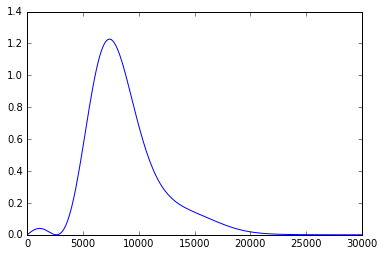

In [41]:
plt.plot(lrange,defl)
#plt.plot(lrange,deflk)

In [10]:
Ahalo = Halo(c180=1,r180=1.0*u.Mpc)
CMB = CMB_Map(halo = Ahalo,npix=400,scale = 240.0)

(0, (400, 400), 0.0)
(10, (400, 400), 165.4977945472386)
(20, (400, 400), 161.40111523778265)
(30, (400, 400), 157.42655430390388)
(40, (400, 400), 153.58359287371812)
(50, (400, 400), 149.88235386462276)
(60, (400, 400), 146.33359149559612)
(70, (400, 400), 142.9486621133615)
(80, (400, 400), 139.7394718753438)
(90, (400, 400), 136.71839671382926)
(100, (400, 400), 133.898170263824)
(110, (400, 400), 131.29173622128698)
(120, (400, 400), 128.9120630507479)
(130, (400, 400), 126.77192118130891)
(140, (400, 400), 124.88362582820855)
(150, (400, 400), 123.2587522247406)
(160, (400, 400), 121.90783403867037)
(170, (400, 400), 120.84005958290487)
(180, (400, 400), 120.0629834711765)
(190, (400, 400), 119.58227293374215)
(200, (400, 400), 119.40150752817152)
Domain Error!
(210, (400, 400), 119.52204817522163)
(220, (400, 400), 119.94298645606585)
(230, (400, 400), 120.66117851239477)
(240, (400, 400), 121.67136064004544)
(250, (400, 400), 122.96633685688128)
(260, (400, 400), 124.5372233510

In [11]:
Bhalo = Halo(M14=20,c180=1,r180=1.0*u.Mpc)
CMB2 = CMB_Map(halo = Bhalo,npix=400,scale = 240.0)

(0, (400, 400), 0.0)
(10, (400, 400), 165.4977945472386)
(20, (400, 400), 161.40111523778265)
(30, (400, 400), 157.42655430390388)
(40, (400, 400), 153.58359287371812)
(50, (400, 400), 149.88235386462276)
(60, (400, 400), 146.33359149559612)
(70, (400, 400), 142.9486621133615)
(80, (400, 400), 139.7394718753438)
(90, (400, 400), 136.71839671382926)
(100, (400, 400), 133.898170263824)
(110, (400, 400), 131.29173622128698)
(120, (400, 400), 128.9120630507479)
(130, (400, 400), 126.77192118130891)
(140, (400, 400), 124.88362582820855)
(150, (400, 400), 123.2587522247406)
(160, (400, 400), 121.90783403867037)
(170, (400, 400), 120.84005958290487)
(180, (400, 400), 120.0629834711765)
(190, (400, 400), 119.58227293374215)
(200, (400, 400), 119.40150752817152)
Domain Error!
(210, (400, 400), 119.52204817522163)
(220, (400, 400), 119.94298645606585)
(230, (400, 400), 120.66117851239477)
(240, (400, 400), 121.67136064004544)
(250, (400, 400), 122.96633685688128)
(260, (400, 400), 124.5372233510

In [12]:
Chalo = Halo(M14=0.2,c180=1,r180=1.0*u.Mpc)
CMB3 = CMB_Map(halo = Chalo,npix=400,scale = 240.0)

(0, (400, 400), 0.0)
(10, (400, 400), 165.4977945472386)
(20, (400, 400), 161.40111523778265)
(30, (400, 400), 157.42655430390388)
(40, (400, 400), 153.58359287371812)
(50, (400, 400), 149.88235386462276)
(60, (400, 400), 146.33359149559612)
(70, (400, 400), 142.9486621133615)
(80, (400, 400), 139.7394718753438)
(90, (400, 400), 136.71839671382926)
(100, (400, 400), 133.898170263824)
(110, (400, 400), 131.29173622128698)
(120, (400, 400), 128.9120630507479)
(130, (400, 400), 126.77192118130891)
(140, (400, 400), 124.88362582820855)
(150, (400, 400), 123.2587522247406)
(160, (400, 400), 121.90783403867037)
(170, (400, 400), 120.84005958290487)
(180, (400, 400), 120.0629834711765)
(190, (400, 400), 119.58227293374215)
(200, (400, 400), 119.40150752817152)
Domain Error!
(210, (400, 400), 119.52204817522163)
(220, (400, 400), 119.94298645606585)
(230, (400, 400), 120.66117851239477)
(240, (400, 400), 121.67136064004544)
(250, (400, 400), 122.96633685688128)
(260, (400, 400), 124.5372233510

In [13]:
fac = 1.
grad = 10.0
CMB.TLmap =  CMB.Tmap + fac*((np.multiply(CMB.alphax,grad)-np.multiply(CMB.alphay,0)))

CMB2.TLmap =  CMB2.Tmap + fac*((np.multiply(CMB2.alphax,grad)-np.multiply(CMB2.alphay,0)))
CMB3.TLmap =  CMB3.Tmap + fac*((np.multiply(CMB3.alphax,grad)-np.multiply(CMB3.alphay,0)))

l_fac = np.divide(l2(size=400),ly(size=400))#[30:-30,30:-30]
#im = gaussian_filter(CMB.TLmap-CMB.Tmap,5,mode="nearest")[30:-30,30:-30]
im = gaussian_filter(noisify(CMB.TLmap-CMB.Tmap,2.2),5,mode="nearest")#[30:-30,30:-30]
im2 = noisify(gaussian_filter(CMB3.TLmap-CMB3.Tmap,5,mode="nearest"),27)#[30:-30,30:-30]

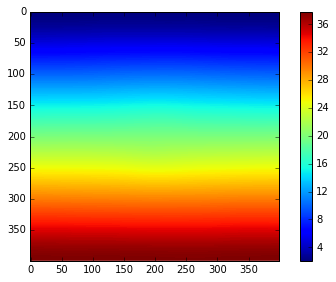

In [14]:
display_map(gaussian_filter(noisify(CMB.TLmap,2),25),lab=False,fig_name="z1m1.pdf")

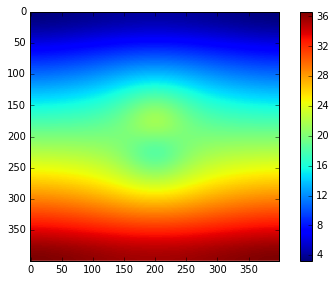

In [15]:
display_map(gaussian_filter(CMB2.TLmap,25),lab=False,fig_name="z1m3.pdf")

In [16]:
fft_im=np.fft.fft2(im)
fft_im2=np.fft.fft2(im2)

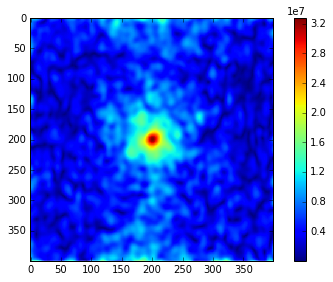

In [17]:
display_map(abs(np.fft.ifft2(-1j*np.multiply(l_fac,fft_im))),lab=False,fig_name="kappa_map.pdf")

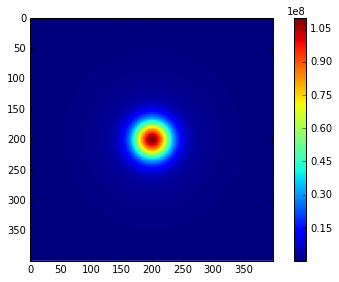

In [18]:
display_map(gaussian_filter(5.4/2.25*CMB.kappa*10**18,20,mode="nearest"),lab=False)

In [19]:
Alg = lgl(halo=Ahalo,size=400,scale=1)

In [20]:
Alg = np.nan_to_num(Alg)

Bll_l = bll(size=400)

Bll_l = np.nan_to_num(Bll_l)

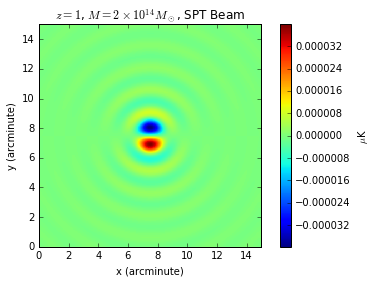

In [21]:
display_map(gaussian_filter(Alg,5))

In [182]:
Bll_l = 1
A3 = np.sum(np.nan_to_num(np.multiply(Alg,np.fft.fft2(gaussian_filter(CMB3.TLmap-CMB3.Tmap,5))))) # M = 0.2
A2 = np.sum(np.nan_to_num(np.multiply(Alg,np.fft.fft2(gaussian_filter(CMB2.TLmap-CMB2.Tmap,5))))) 
A = np.sum(np.nan_to_num(np.multiply(Alg,np.fft.fft2(gaussian_filter(CMB.TLmap-CMB.Tmap,5))))) 
#A2 = np.sum(np.nan_to_num(np.divide(np.multiply(np.fft.fftshift((gaussian_filter(Alg,5))),np.fft.ifft2(gaussian_filter(CMB2.TLmap-CMB2.Tmap,5)),Bll_l))) # M = 0.2
#A = np.sum(np.nan_to_num(np.divide(np.multiply(np.fft.fftshift((gaussian_filter(Alg,5))),np.fft.ifft2(gaussian_filter(CMB.TLmap-CMB.Tmap,5))),Bll_l)) )# M = 0.2


In [183]:
(A.real/A2.real), (A.real/A3.real)

(0.1000000000000127, 10.000000000003466)

In [24]:
def operations(x):
    return np.multiply(gaussian_filter(Alg,25),
                              np.fft.fft2(gaussian_filter(noisify(x.TLmap-x.Tmap,0.22),25)))

In [25]:
l_w = 0.0125
A3 = np.sum(operations(CMB3))
A2 = np.sum(operations(CMB2))
A = np.sum(operations(CMB))

In [26]:
(A2.real/A.real),(A3.real/A.real)

(3.9575364606842918, 3.071877997373516)

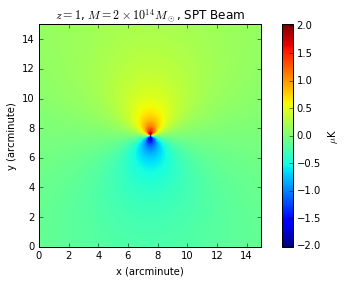

In [32]:
x=CMB
display_map((x.TLmap-x.Tmap))

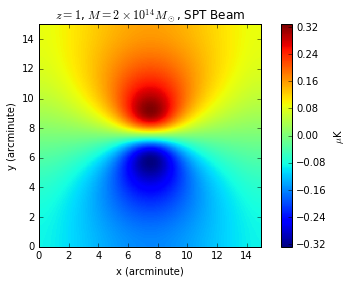

In [28]:
x=CMB
y = CMB3
display_map((gaussian_filter(x.TLmap-x.Tmap,25))-3.35*(gaussian_filter(y.TLmap-y.Tmap,25)))

In [29]:
Chalo.rs

<Quantity 1.0 Mpc>

In [30]:
(A2.real/A.real),(A3.real/A.real)

(3.9575364606842918, 3.071877997373516)

In [197]:
A = np.sum(np.multiply(gaussian_filter(Alg,25),
                              np.fft.fft2(gaussian_filter(CMB.TLmap-CMB.Tmap,25))))
array_m = []
array_p = []
array_z = []

for i in range(0,400):
    A2 = np.sum(operations(CMB2)) # M = 10
    array_p.append((A2.real/A.real))
    A3 = np.sum(operations(CMB3))
    array_m.append((A3.real/A.real))
    Ap = np.sum(operations(CMB))
    array_z.append((Ap.real/A.real))

In [187]:
A = np.sum(np.multiply(gaussian_filter(Alg,25),
                              np.fft.fft2(gaussian_filter(CMB.TLmap-CMB.Tmap,25))))
A2

(0.00022744237789191829-0.15737403537537148j)

In [200]:
array_p2 = np.array(array_p)*2
array_m2 = np.array(array_m)*2
array_z2 = np.array(array_z)*2

np.mean(array_p2), np.std(array_p2),np.mean(array_z2), np.std(array_z2),np.mean(array_m2), np.std(array_m2)

(18.737122830739505,
 33.679797541278731,
 1.8303825692499067,
 34.670167492489661,
 -0.055101914650965395,
 36.016422831720163)

[[ 20.          18.73712283   1.06504871]
 [  2.           1.83038257   1.09636696]
 [  0.2         -0.05510191   1.13893929]]


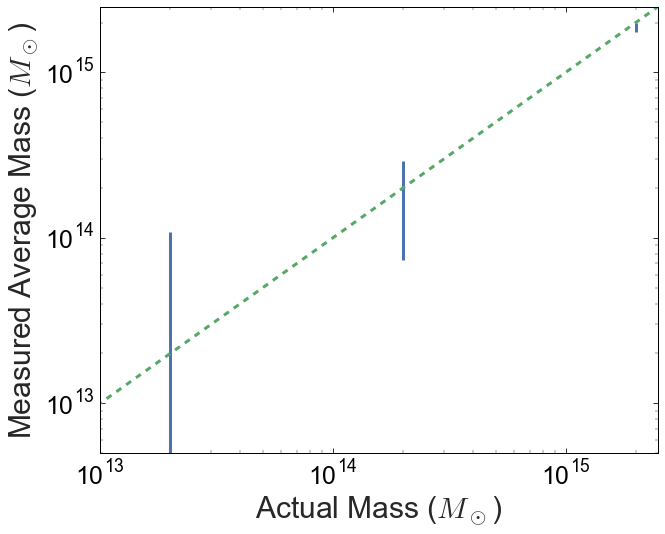

In [203]:
num = 1000
re = np.array([[20.0,np.mean(array_p2),np.std(array_p2)/sqrt(num)],[2.0,np.mean(array_z2),np.std(array_z2)/sqrt(num)],[0.2,np.mean(array_m2),np.std(array_m2)/sqrt(num)]])
print re
line = np.array([[0.001,0.001],[30,30]])
#plt.figure(figsize=(20,20))

fig, ax = plt.subplots(1,1,figsize=(10,8))

plt.errorbar(re[:,0]*10**(14),re[:,1]*10**(14),re[:,2]*10**(14),fmt='.')
plt.loglog(line[:,0]*10**(14),line[:,1]*10**(14),'--')
ax.set_yscale('log')
ax.set_xscale('log')

plt.ylabel(r'Measured Average Mass ($M_\odot$)',fontsize=30)
plt.xlabel(r'Actual Mass ($M_\odot$)',fontsize=30)


plt.setp(ax.get_xticklabels(), visible=True,fontsize=25)
plt.setp(ax.get_yticklabels(), visible=True,fontsize=25)

plt.xlim(0.1*10**(14),25*10**(14))
plt.ylim(0.5*10**(13),25*10**(14))
plt.savefig("Seljak-Zaldarriaga.pdf")

In [176]:
0.23046854/2.38532526

0.09661933484073362

In [ ]:
num = 1000
re = np.array([[12.,0.96*2/10],[6.0,0.96/10],[0.0,0.0]])
hu = np.genfromtxt('TT_hu',delimiter=',')
print re
#line = np.array([[0.001,0.001],[30,30]])
#plt.figure(figsize=(20,20))

fig, ax = plt.subplots(1,1,figsize=(10,8))

plt.plot(re[:,0],re[:,1],label = 'Matched Filter')
plt.plot(hu[:,0],hu[:,1],label = 'Hu, De Deo, Vale')
#plt.loglog(line[:,0]*10**(14),line[:,1]*10**(14),'--')
ax.set_yscale('log')
ax.set_xscale('log')

plt.ylabel(r'$\Delta M / M (N/10^{3})^{1/2}$',fontsize=30)
plt.xlabel(r"$\Delta_T$ ($\mu$K ')",fontsize=30)
plt.setp(ax.get_xticklabels(), visible=True,fontsize=25)
plt.setp(ax.get_yticklabels(), visible=True,fontsize=25)

plt.legend(loc=4, fontsize=25)


plt.xlim(0.5,10)
plt.ylim(0.005,.3)

#plt.ylim(0.5*10**(13),25*10**(14))
plt.savefig("Seljak-Zaldarriaga-Filter.pdf")

In [55]:
import seaborn as sns

/Users/bhorowitz/virtual/_notebook/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [56]:
sns.set_style('whitegrid', {'axes.grid' : False, 'axes.ticks' : True, \
                            'xtick.major.size': 5.0, 'xtick.minor.size': 3, \
                            'xtick.color' : 'k', 'xtick.direction': u'in', \
                           'ytick.major.size': 5.0, 'ytick.minor.size': 3, \
                            'ytick.color' : 'k', 'ytick.direction': u'in', \
                           'axes.edgecolor':'k','font_scale':2})
#sns.set_context('paper')


paper_rc = {'lines.linewidth': 3, 'lines.markersize': 5}                  
sns.set_context("paper", rc = paper_rc)                                    

#fmtest = fm.FontProperties(style='italic', weight='ultralight')


In [ ]:
re = np.array([[5.0,2.41194674947],[1,1],[0.1,0.276758106434]])
plt.loglog(re[:,0],re[:,1])

In [ ]:
log(5.0)/log(2.41194674947)

In [ ]:
log(.1)/log(0.276758106434)

In [ ]:
errors=[]

for i in range(0,100):
    A2 = np.sum(np.multiply((Alg),noisify(gaussian_filter(CMB.TLmap-CMB.Tmap,25),2.7)))
    #A2
    errors.append([A2/A])

In [ ]:
np.std(errors)

In [ ]:
A2

In [ ]:
Algp = Alg
Algp[0:10] = nan

In [ ]:
display(gaussian_filter(noisifyCMB2.TLmap,25))

In [ ]:
A2/A

In [ ]:
np.sum(np.multiply(Alg,Alg))

In [ ]:
from scipy import integrate

In [180]:
def bl_n(l,noise,fac=0.0):
    wt = noise**2.
    try:
        return (wt+fac*lensed_tt(l))
    except:
        return np.infty
    
def _gl_integrand(i,args):
    l,halo=args[0],args[1]
    scale = 0.00003
   # print i,halo.defl2(i*u.Mpc/scale).value,
   # print i,l
    return i*((halo.defl2(i*u.Mpc/scale).value))*special.j1(i*l)

def gl(l,halo,low=0.0000001,high=0.1,precision = 10000):
    return integrate.quad(_gl_integrand,low,high,args=[l,halo])[0]

1.0

In [144]:
l =4000
noise = 0.0022
(bl_n(l,noise,0.22,fac=1.0)-bl_n(l,noise,0.22,fac=0.0))/bl_n(l,noise,0.22,fac=0.0)

0.040683254270369652

In [ ]:
lrange = np.linspace(0.001,25000,200)
grange = [gl(l,Ahalo) for l in lrange]
#deflect = [halo.defl2(i*scale*u.Mpc).value for i in lrange]
#integrand = [l*gl(l,Ahalo)**2/bl_n(l,.22,.25) for l in lrange] #.3

In [205]:
integrand = np.nan_to_num([l*defl[i]/bl_n(l,.22,fac=0.0) for i,l in enumerate(lrange)]) #.3
integrand1 = np.nan_to_num([l*defl[i]/bl_n(l,.22,fac=1.0) for i,l in enumerate(lrange)]) #.3
y=np.sqrt(np.pi*np.sum(np.array(integrand)*(lrange[1]-lrange[0])))
y1=np.sqrt(np.pi*np.sum(np.array(integrand1)*(lrange[1]-lrange[0])))

(-1/(-A.real*y1))/sqrt(1000),(-1/(A.real*y))/sqrt(1000), ((-1/(A.real*y))/sqrt(1000)-(-1/(A.real*y1))/sqrt(1000))/((-1/(A.real*y))/sqrt(1000))

(-0.7165073094977007, 0.71649639790224051, -1.5229100232925788e-05)

In [ ]:
lrange =  np.linspace(10, 25000,100)
defl = [Ahalo.deflect_l(l/1660)**2*exp(-(l/1660.)**2*.20**2)*l/(0.22+l*(1+l)*lensed_tt(l)) for l in lrange]
#deflk = [gl(l/1660,Ahalo)*exp(-(l/1660)**2*.20**2) for l in lrange]

In [ ]:
1/(A.real/(1/y)*sqrt(1000))

In [ ]:
bl_ra=np.array([bl_n(1440/l,.22,.00010,fac=0.0) for l in lrange])

In [ ]:
plt.loglog(np.divide(1,lrange),bl_ra[:])

In [ ]:
A.real*sqrt(np.pi*np.sum(np.array(integrand)*(lrange[1]-lrange[0])))#/gl(1.0,Ahalo)**2

In [ ]:
.3/.2,.3/2,.3/20

In [ ]:
y =np.sqrt(np.pi*np.sum(np.array(integrand)*(lrange[1]-lrange[0])))

In [ ]:
y

In [ ]:
A

In [ ]:
(1/(A.real*y))/sqrt(1000)

In [ ]:
bl_n(1,.1,1),bl_n(1,.1,1,fac=1.0)

In [ ]:
# 1 =25 corresponds to l_cmb = 20,000, l = 50 to l_cmb = 10,0000

In [37]:
cmb_unlensed = np.genfromtxt("/Users/bhorowitz/Downloads/explanatory03_cl.dat")
cmb_lensed = np.genfromtxt("/Users/bhorowitz/Downloads/explanatory03_cl_lensed.dat")

In [89]:
from scipy import interpolate
lensed_tt = interpolate.interp1d(cmb_lensed[:,0],np.divide(cmb_lensed[:,1]*10**12*(2.7)**2,np.power(cmb_lensed[:,0],2)))
#lensed_tt = interpolate.interp1d(cmb_lensed[:,0],np.divide(cmb_lensed[:,1]*10**12*(2.7)**2,np.power(cmb_lensed[:,0],2)))

In [ ]:
lensed_tt(10)

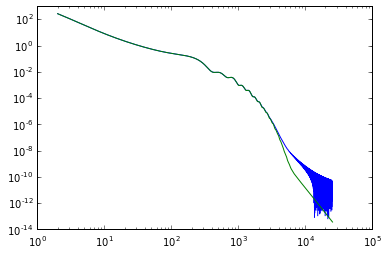

In [38]:
plt.loglog(cmb_lensed[:,0],np.divide(cmb_lensed[:,1]*10**12*(2.7)**2,np.power(cmb_lensed[:,0],2)))
plt.loglog(cmb_unlensed[:,0],np.divide(cmb_unlensed[:,1]*10**12*(2.7)**2,np.power(cmb_unlensed[:,0],2)))

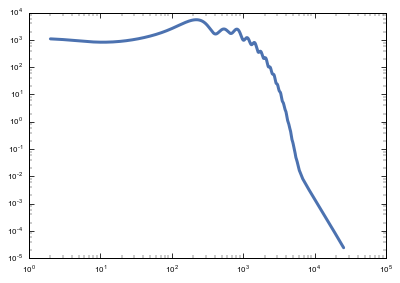

In [67]:
plt.loglog(cmb_unlensed[:,0],cmb_unlensed[:,1]*10**12*(2.7)**2)

In [35]:
cmb_lensed[:,0]

array([  2.00000000e+00,   3.00000000e+00,   4.00000000e+00, ...,
         2.54980000e+04,   2.54990000e+04,   2.55000000e+04])

In [45]:
garange = interpolate.interp1d(lrange,defl)#,#np.power(grange,2)*10

In [46]:
garange(cmb_lensed[80:-1000,0])

array([ 0.00465979,  0.00471662,  0.00477345, ...,  0.00137481,
        0.00137398,  0.00137315])

In [ ]:
cmb_lensed[:-1000,0]

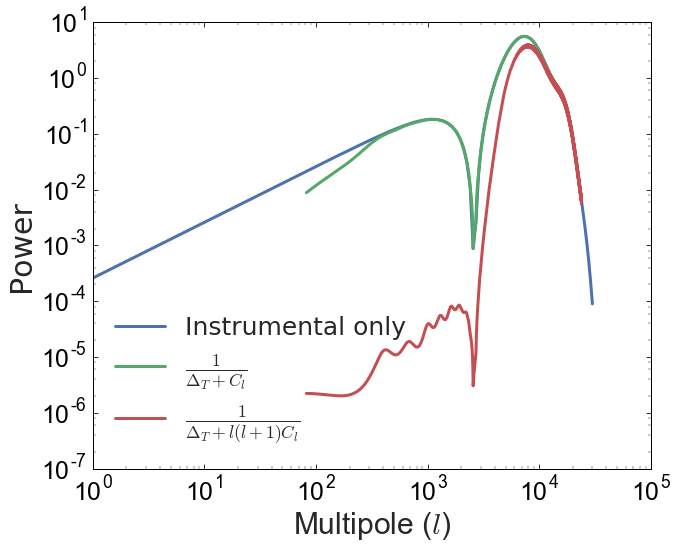

In [66]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

r = np.array([[0.001,6.0],[100000,6.0]])

plt.loglog(lrange,np.array(defl)/0.22,label = "Instrumental only")
#plt.loglog(cmb_lensed[:,0],np.divide(garange(cmb_lensed[:,0]),6*np.ones(len(cmb_lensed[:,1]))+np.divide(cmb_lensed[:,1]*10**12*(2.7)**2,np.power(cmb_lensed[:,0],2))),label = r"$\frac{1}{\Delta_T + C_{l}}$")
#plt.loglog(cmb_lensed[:,0],np.divide(1,6*np.ones(len(cmb_lensed[:,1]))+np.divide(cmb_lensed[:,1]*10**12*(2.7)**2,np.power(cmb_lensed[:,0],0))),label = r"$\frac{1}{\Delta_T + l(l+1)C_{l}}$")
#plt.loglog(r[:,0],r[:,1],"o--")

plt.loglog(cmb_lensed[80:-1000,0],np.divide(garange(cmb_lensed[80:-1000,0]),.22*np.ones(len(cmb_lensed[80:-1000,1]))+np.divide(cmb_lensed[80:-1000,1]*10**12*(2.7)**2,np.power(cmb_lensed[80:-1000,0],2))),label = r"$\frac{1}{\Delta_T + C_{l}}$")
plt.loglog(cmb_lensed[80:-1000,0],np.divide(garange(cmb_lensed[80:-1000,0]),.22*np.ones(len(cmb_lensed[80:-1000,1]))+np.divide(cmb_lensed[80:-1000,1]*10**12*(2.7)**2,np.power(cmb_lensed[80:-1000,0],0))),label = r"$\frac{1}{\Delta_T + l(l+1)C_{l}}$")



plt.ylabel(r'Power',fontsize=30)
plt.xlabel(r"Multipole ($l$)",fontsize=30)
plt.setp(ax.get_xticklabels(), visible=True,fontsize=25)
plt.setp(ax.get_yticklabels(), visible=True,fontsize=25)

plt.xlim(1,100000)
#plt.ylim(0.001,0.5)

plt.legend(loc=3, fontsize=25)

plt.savefig("integrand_power_updated.pdf")

In [ ]:
plt.semilogx(np.divide(1440,lrange),grange)


In [ ]:
Ahalo.defl2(1.*u.Mpc)